#Project Code


---


## Task 1 training Resnet-18 ( CNN ) Model on Colorectal cancer dataset.

###Imports

In [46]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import time
from typing_extensions import Self
from scipy import stats
from sklearn.manifold import TSNE
import plotly.express as px
from sklearn.metrics import multilabel_confusion_matrix

In [16]:
pip install thop

In [15]:
from thop import profile

### Importing datasets from github.

In [2]:
!wget -q https://raw.githubusercontent.com/tsunrise/colab-github/main/colab_github.py
import colab_github
colab_github.github_auth(persistent_key=True)

# method to import git data into colab taken from:
# https://github.com/tsunrise/colab-github

Mounted at /content/drive/
Looks that a private key is already created. If you have already push it to github, no action required.
 Otherwise, Please go to https://github.com/settings/ssh/new to upload the following key: 
ssh-ed25519 AAAAC3NzaC1lZDI1NTE5AAAAIKsdgQltK+JTZbl5J1o7j408pGhjNyf4YUbWJmSugvZz root@b884b6fcbf02

Please use SSH method to clone repo.


cloning

In [3]:
!git clone git@github.com:jonq-q/Comp432-GroupQ.git

Cloning into 'Comp432-GroupQ'...
remote: Enumerating objects: 18090, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (36/36), done.
Receiving objects: 100% (18090/18090), 1.14 GiB | 37.59 MiB/s, done.
remote: Total 18090 (delta 13), reused 0 (delta 0), pack-reused 18054
Resolving deltas: 100% (30/30), done.
Updating files: 100% (18018/18018), done.


### Data Onboarding

In [4]:
dataset = datasets.ImageFolder("/content/Comp432-GroupQ/Dataset 1/Colorectal Cancer /", transforms.Compose([
        torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]))

train_set, test_set = torch.utils.data.random_split(dataset,[0.7,0.3])                # splits dataset into specified ratios
train_loader = DataLoader(train_set,shuffle=True,batch_size=32, num_workers=0)         # create train loader
test_loader = DataLoader(test_set,batch_size=32, num_workers=0)  # create test loader

### Model 1 creation: Resnet - 18: CNN (no pretraining)

In [5]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)

if torch.cuda.is_available():
    model = model.to('cuda')

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model training

In [6]:
num_epochs = 20
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    current_loss = 0.0
    correct = 0
    total = 0
    round = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
        y_pred = model(inputs)
        l = loss(y_pred, labels)
        l.backward()
        optimizer.step()

        current_loss += l.item()
        _, predicted = torch.max(y_pred.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Training time for one epoch: {elapsed_time} seconds")
    train_accuracy = 100 * correct / total
    train_loss = current_loss / len(train_loader)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')

Training time for one epoch: 47.44942259788513 seconds
Epoch 1/20, Loss: 1.3589, Accuracy: 73.36%
Training time for one epoch: 38.121204137802124 seconds
Epoch 2/20, Loss: 0.4742, Accuracy: 82.69%
Training time for one epoch: 42.54208850860596 seconds
Epoch 3/20, Loss: 0.3996, Accuracy: 85.07%
Training time for one epoch: 38.707048416137695 seconds
Epoch 4/20, Loss: 0.3212, Accuracy: 87.62%
Training time for one epoch: 38.991645097732544 seconds
Epoch 5/20, Loss: 0.2919, Accuracy: 89.07%
Training time for one epoch: 38.111873626708984 seconds
Epoch 6/20, Loss: 0.2630, Accuracy: 90.31%
Training time for one epoch: 40.24288511276245 seconds
Epoch 7/20, Loss: 0.2573, Accuracy: 90.33%
Training time for one epoch: 38.60943913459778 seconds
Epoch 8/20, Loss: 0.2333, Accuracy: 91.12%
Training time for one epoch: 37.992088079452515 seconds
Epoch 9/20, Loss: 0.2051, Accuracy: 92.43%
Training time for one epoch: 39.68050956726074 seconds
Epoch 10/20, Loss: 0.1924, Accuracy: 92.45%
Training time 

Flop calculation

In [17]:
# Input tensor (batch size, channels, height, width)
input_tensor = torch.randn(1, 3, 224, 224).to('cuda')

flops, params = profile(model, inputs=(input_tensor,))

print(f"Number of FLOPs: {flops / 1e9} G FLOPs")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
Number of FLOPs: 1.824033792 G FLOPs


Code validation

In [18]:
val_loss = []

with torch.no_grad():
          model.eval()
          running_loss = 0.0
          running_score = 0.0
          for image,label in test_loader:
                image = image.to('cuda')
                label = label.to('cuda')
                optimizer.zero_grad()
                y_pred = model.forward(image)
                l = loss(y_pred,label)
                running_loss += l.item()

                val, index_ = torch.max(y_pred,axis=1)
                running_score += torch.sum(index_ == label.data).item()

          epoch_score = running_score/len(test_loader.dataset)
          epoch_loss = running_loss/len(test_loader.dataset)
          val_loss.append(epoch_loss)
          print("Validation loss: {}, accuracy: {}".format(epoch_loss,epoch_score))

          all_predictions = []
          true_labels = []
          for inputs, labels in test_loader:
              inputs, labels = inputs.to('cuda'), labels.to('cuda')
              outputs = model.forward(inputs)
              _, predicted = torch.max(outputs.data, 1)
              all_predictions.extend(predicted.cpu().numpy())
              true_labels.extend(labels.cpu().numpy())

classification_rep = classification_report(true_labels, all_predictions, target_names=dataset.classes)
print(classification_rep)

Validation loss: 0.0049307948500952785, accuracy: 0.9411111111111111
              precision    recall  f1-score   support

         MUS       0.98      0.86      0.92       588
        NORM       0.98      0.99      0.98       615
         STR       0.87      0.97      0.92       597

    accuracy                           0.94      1800
   macro avg       0.94      0.94      0.94      1800
weighted avg       0.95      0.94      0.94      1800



Saving trained model (note: may require adjusting directories depending on your drive)

In [24]:
torch.save(model.state_dict(), '/content/drive/My Drive/TrainedModel')

In [ ]:
pretrained_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)

#RostislavRu
#pretrained_model.load_state_dict(torch.load('/content/drive/My Drive/Comp 432/TrainedModel', map_location=torch.device('cuda')),strict=False)

#Jonq-q
pretrained_model.load_state_dict(torch.load('/content/drive/My Drive/TrainedModel', map_location=torch.device('cuda')),strict=False)

Checking model after saving

In [26]:
pretrained_model.to('cuda')

with torch.no_grad():
          pretrained_model.eval()
          all_predictions = []
          true_labels = []
          for inputs, labels in test_loader:
              inputs, labels = inputs.to('cuda'), labels.to('cuda')
              outputs = pretrained_model.forward(inputs)
              _, predicted = torch.max(outputs.data, 1)
              all_predictions.extend(predicted.cpu().numpy())
              true_labels.extend(labels.cpu().numpy())

classification_rep = classification_report(true_labels, all_predictions, target_names=dataset.classes)
print(classification_rep)

              precision    recall  f1-score   support

         MUS       0.98      0.86      0.92       588
        NORM       0.98      0.99      0.98       615
         STR       0.87      0.97      0.92       597

    accuracy                           0.94      1800
   macro avg       0.94      0.94      0.94      1800
weighted avg       0.94      0.94      0.94      1800



Confusion matrix

In [36]:
confMatrix = multilabel_confusion_matrix(true_labels, all_predictions, labels=[0, 1, 2])
print(confMatrix)

[[[1204    8]
  [  85  503]]

 [[1174   11]
  [   8  607]]

 [[1114   89]
  [  15  582]]]


Model layers

In [ ]:
pretrained_model

### Model visualization on Dataset 1 with t-SNE

### Approach 1

In [38]:
device=torch.device("cuda:0"if torch.cuda.is_available() else "cpu")

In [39]:
from typing_extensions import Self
#print(list(pretrained_model.children()))
features=list(pretrained_model.children())[:-1] #only remove fc
model_out=nn.Sequential(*features).to(device)
def for_feature(loader):
  data_tmp=[]
  label_tmp=[]

  with torch.no_grad():
      for img,label in loader:
        img=img.to(device)

        output1=model_out(img)

        data_tmp.append(output1.cpu().numpy())
        label_tmp.append(label.cpu().numpy())

  return np.vstack(data_tmp), np.hstack(label_tmp)

In [40]:
trained_feature, trained_label=for_feature(train_loader)

In [41]:
trained_feature_n = trained_feature.reshape(4200,512)

In [42]:
from scipy import stats
stats.describe(trained_label)

DescribeResult(nobs=4200, minmax=(0, 2), mean=0.9978571428571429, variance=0.6703931208110775, skewness=0.003947103158719484, kurtosis=-1.5079722324533877)

In [47]:
tsne=TSNE(n_components=2, random_state=0, learning_rate='auto')
projections=tsne.fit_transform(trained_feature_n)
fig=px.scatter(projections[:,0], projections[:,1], color = trained_label, labels={"color":""})
fig.show()

### Approach 2

In [ ]:
dataset1 = datasets.ImageFolder("/content/Comp432-GroupQ/Dataset 1/Colorectal Cancer ", transforms.Compose([
        torchvision.transforms.Resize((224,224)),
        torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]))

dataloader_sc = DataLoader(dataset1, batch_size=64, shuffle=True)

In [ ]:
features = list(pretrained_model.children())[:-1] #only remove fc
resnet_nohead = nn.Sequential(*features).to(device)
resnet_nohead = resnet_nohead.eval()

In [ ]:
all_features = []
all_labels = []

resnet_nohead.to(device)

with torch.no_grad():
    for images, labels in dataloader_sc:
        images = images.to(device)
        labels = labels.to(device)
        features = resnet_nohead(images)
        features = features.squeeze().cpu().numpy()
        all_features.append(features)
        all_labels.append(labels.cpu().numpy())

# Concatenate features and labels
all_features = np.concatenate(all_features, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
embedded_features = tsne.fit_transform(all_features)

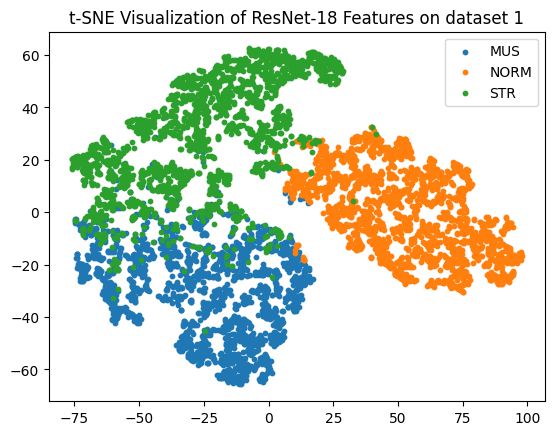

In [ ]:
# Plot the t-SNE embeddings with different colors for each class
plt.scatter(embedded_features[all_labels == 0, 0], embedded_features[all_labels == 0, 1], label='MUS',s=10)
plt.scatter(embedded_features[all_labels == 1, 0], embedded_features[all_labels == 1, 1], label='NORM',s=10)
plt.scatter(embedded_features[all_labels == 2, 0], embedded_features[all_labels == 2, 1], label='STR',s=10)

plt.title('t-SNE Visualization of ResNet-18 Features on dataset 1')
plt.legend()
plt.show()

In [ ]:
#task 2 Pretrained ResNet18 applied to Dataset2 & 3
dataset2 = datasets.ImageFolder("/content/Comp432-GroupQ/Dataset 2/Prostate Cancer/", transforms.Compose([
        torchvision.transforms.Resize((224,224)),
        torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]))

dataloader_sc1 = DataLoader(dataset2, batch_size=64, shuffle=True)

In [ ]:
features = list(pretrained_model.children())[:-1] #only remove fc
resnet_nohead = nn.Sequential(*features).to(device)
resnet_nohead = resnet_nohead.eval()

## Task 2: Pre-trained CNN applications on different datasets

###Scenario 1: Locally trained CNN on dataset 2, with KNN and SVM classification

model output extraction

In [ ]:
all_features = []
all_labels = []

resnet_nohead.to(device)

with torch.no_grad():
    for images, labels in dataloader_sc1:
        images = images.to(device)
        labels = labels.to(device)
        features = resnet_nohead(images)
        features = features.squeeze().cpu().numpy()
        all_features.append(features)
        all_labels.append(labels.cpu().numpy())

# Concatenate features and labels
all_features = np.concatenate(all_features, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

t-SNE

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
embedded_features = tsne.fit_transform(all_features)

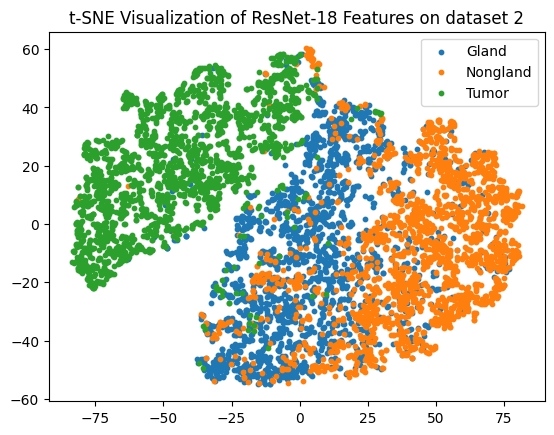

In [ ]:
# Plot the t-SNE embeddings with different colors for each class
plt.scatter(embedded_features[all_labels == 0, 0], embedded_features[all_labels == 0, 1], label='Gland',s=10)
plt.scatter(embedded_features[all_labels == 1, 0], embedded_features[all_labels == 1, 1], label='Nongland',s=10)
plt.scatter(embedded_features[all_labels == 2, 0], embedded_features[all_labels == 2, 1], label='Tumor',s=10)

plt.title('t-SNE Visualization of ResNet-18 Features on dataset 2')
plt.legend()
plt.show()

### KNN classification

In [ ]:
def extract_features(model, dataloader):
    model.eval()
    all_features, all_labels = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            features = model(images)
            all_features.append(features.squeeze().cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.vstack(all_features), np.array(all_labels)

# Extract features from the dataset
features, labels = extract_features(resnet_nohead, dataloader_sc1)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# Create k-NN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(X_train, y_train)

# Evaluate the model
accuracy = knn_classifier.score(X_test, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 89.44%


In [ ]:
y_pred_knn = knn_classifier.predict(X_test)

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred_knn))

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.85      0.84       596
           1       0.86      0.87      0.87       598
           2       0.99      0.96      0.97       606

    accuracy                           0.89      1800
   macro avg       0.90      0.89      0.89      1800
weighted avg       0.90      0.89      0.89      1800



In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

confMatrix_knn = multilabel_confusion_matrix(y_test, y_pred_knn)
print(confMatrix_knn)

[[[1107   97]
  [  91  505]]

 [[1117   85]
  [  75  523]]

 [[1186    8]
  [  24  582]]]


### SVM Classification

In [ ]:
from sklearn import svm

svm_classifier = svm.SVC()
svm_classifier.fit(X_train, y_train)

# Evaluate the SVM model
y_pred_svm = svm_classifier.predict(X_test)

In [ ]:
print("Classification Report (SVM):\n", classification_report(y_test, y_pred_svm))

Classification Report (SVM):
               precision    recall  f1-score   support

           0       0.85      0.86      0.86       596
           1       0.88      0.88      0.88       598
           2       0.98      0.97      0.98       606

    accuracy                           0.90      1800
   macro avg       0.90      0.90      0.90      1800
weighted avg       0.90      0.90      0.90      1800



In [ ]:
confMatrix_svm = multilabel_confusion_matrix(y_test, y_pred_svm)
print(confMatrix_svm)

[[[1112   92]
  [  81  515]]

 [[1128   74]
  [  74  524]]

 [[1185    9]
  [  20  586]]]
